In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import ks_2samp
import scipy as st
import scipy.stats
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
########################
##FONCTIONS DE CALCULS##
########################

def eta_squared(x,y):

  """Fonction qui calcule l'effet de la taille dans le cadre d'une ANOVA à un facteur
  Entrées : 
  - une variable catégorielle x,
  - une variable quantitative y.

  Sortie :
  - résultat de l'eta-carré
  """
  moyenne_y = y.mean()
  classes = []
  for classe in x.unique():
    yi_classe = y[x==classe]
    classes.append({'ni': len(yi_classe),
                    'moyenne_classe': yi_classe.mean()})
  SCT = sum([(yj-moyenne_y)**2 for yj in y])
  SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
  return SCE/SCT

def distrib_normal(z):
  """Fonction qui trace la distribution d'une variable et qui calcule la symétrie, 
  le coefficient d'applatissement et le respect à une loi statistique : ici la loi normale
  Entrée : 
  - Colonne d'une variable

  Sortie : 
  - Graphique de distribution
  - Résultat de la symétrie
  - Résultat du coefficient d'applatissement
  - Résultat à l'adéquation à la loi normale
  """
  print(z.capitalize())
  _ = sns.displot(billet[z])
  _ = plt.axvline(x=billet[z].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=billet[z].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
  _ = plt.show()
  print(str(ks_2samp(billet[z],list(np.random.normal(np.mean(billet[z]), np.std(billet[z]), 1000)))))

########################
##FONCTIONS DE DESSINS##
########################

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
  """
  Fonction qui trace le cercle de corrélation de l'ACP

  Entrées : 
  - Coordonnées des points de l'ACP
  - Nombre de composantes
  - Fonction de l'ACP dans sklearn
  - Composantes que l'on souhaite représenter

  Sortie : 
  - Cercle de corrélation  
  """
  for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
      if d2 < n_comp:

          # initialisation de la figure
          fig, ax = plt.subplots(figsize=(10,10))

          # détermination des limites du graphique
          if lims is not None :
              xmin, xmax, ymin, ymax = lims
          elif pcs.shape[1] < 30 :
              xmin, xmax, ymin, ymax = -1, 1, -1, 1
          else :
              xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

          # affichage des flèches
          # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
          if pcs.shape[1] < 30 :
              plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                pcs[d1,:], pcs[d2,:], 
                angles='xy', scale_units='xy', scale=1, color="grey")
              # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
          else:
              lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
              ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
          # affichage des noms des variables  
          if labels is not None:  
              for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                  if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
          # affichage du cercle
          an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
          plt.plot(np.cos(an), np.sin(an))
          plt.axis('equal')

          # définition des limites du graphique
          plt.xlim(xmin, xmax)
          plt.ylim(ymin, ymax)
        
          # affichage des lignes horizontales et verticales
          plt.plot([-1, 1], [0, 0], color='grey', ls='--')
          plt.plot([0, 0], [-1, 1], color='grey', ls='--')

          # nom des axes, avec le pourcentage d'inertie expliqué
          plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
          plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

          plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
          plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
  """Fonction qui trace la représentation des individus sur les plans factoriels

  Entrées :
  - Individus projetés
  - Nombre de composante
  - Fonction de l'ACP issue de Sklearn
  - Composantes que l'on souhaite représenter
  - Variables illustratives

  Sortie : 
  - Projection des individus sur les composantes sélectionnées
  """
  for d1,d2 in axis_ranks:
    if d2 < n_comp:
      # initialisation de la figure       
      fig = plt.figure(figsize=(7,6))
        
      # affichage des points
      if illustrative_var is None:
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
      else:
        illustrative_var = np.array(illustrative_var)
      for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
      plt.legend()

      # affichage des labels des points
      if labels is not None:
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
          plt.text(x, y, labels[i],
          fontsize='14', ha='center',va='center') 
                
      # détermination des limites du graphique
      boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
      plt.xlim([-boundary,boundary])
      plt.ylim([-boundary,boundary])
        
      # affichage des lignes horizontales et verticales
      plt.plot([-100, 100], [0, 0], color='grey', ls='--')
      plt.plot([0, 0], [-100, 100], color='grey', ls='--')

      # nom des axes, avec le pourcentage d'inertie expliqué
      plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
      plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

      plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
      plt.show(block=False)
        



In [3]:
billet=pd.read_csv("notes.csv")

In [4]:
billet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [5]:
print( str(billet.isna().sum()) + '\n')

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64



In [6]:
billet.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [7]:
# Recherche des valeurs dupliquées
print('Valeurs dupliquées : ', billet.duplicated().sum())

Valeurs dupliquées :  0


In [8]:
billet = billet.rename(columns = { 'height_left' : 'hauteur_gauche',
                                          'height_right' : 'hauteur_droite',
                                          'margin_low' : 'marge_inf',
                                          'margin_up' : 'marge_sup',
                                'length':'longueur' })

In [9]:
billet

,is_genuine,diagonal,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,longueur
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [10]:
billet_vrai= billet[billet['is_genuine']== True]

In [11]:
billet_vrai

,is_genuine,diagonal,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,longueur
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
95,True,172.49,103.92,103.91,4.42,2.84,113.38
96,True,172.00,104.32,104.26,4.53,3.04,112.93
97,True,171.49,103.77,103.60,4.01,3.09,112.95
98,True,172.10,103.98,103.86,4.47,3.06,113.00


In [12]:
billet.describe()

,diagonal,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,longueur
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


Diagonal


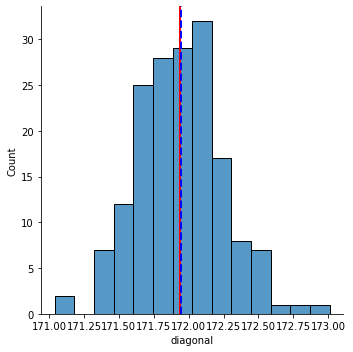

KstestResult(statistic=0.06876470588235294, pvalue=0.47475398905570254)
Hauteur_gauche


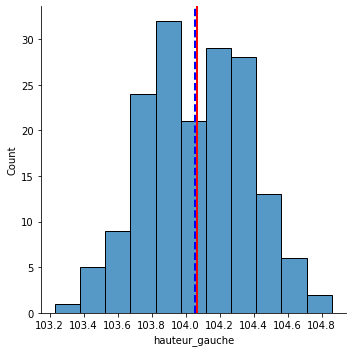

KstestResult(statistic=0.0601764705882353, pvalue=0.6437137496751097)
Hauteur_droite


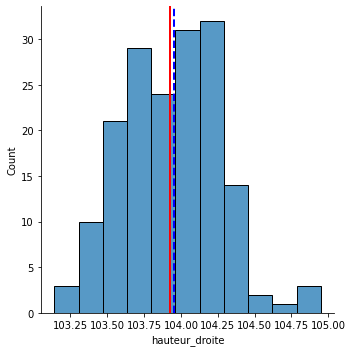

KstestResult(statistic=0.08305882352941177, pvalue=0.2528975038459079)
Marge_inf


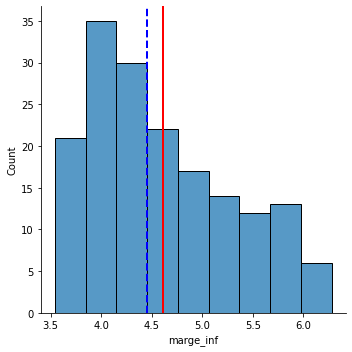

KstestResult(statistic=0.09570588235294118, pvalue=0.129969888725755)
Marge_sup


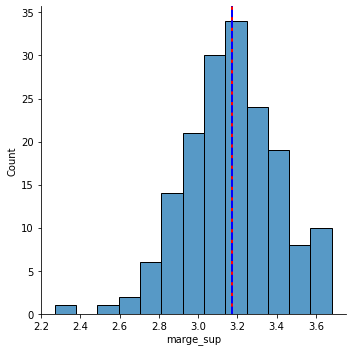

KstestResult(statistic=0.03635294117647059, pvalue=0.9865757315236569)
Longueur


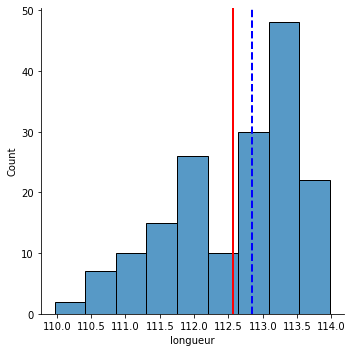

KstestResult(statistic=0.13558823529411765, pvalue=0.008559315325331607)


In [13]:
select=billet[['diagonal','hauteur_gauche','hauteur_droite','marge_inf','marge_sup','longueur']]
for z in select:
    distrib_normal(z)

In [14]:
#On peut de deduire que la longueur des billets et la marge inf ne suivent pas la loi normal 
#on effectuera un test de man withney par la suite 




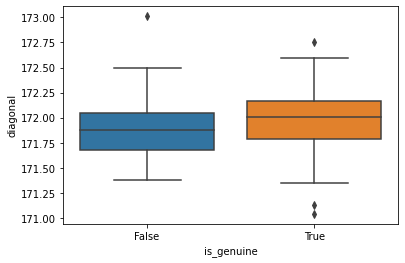

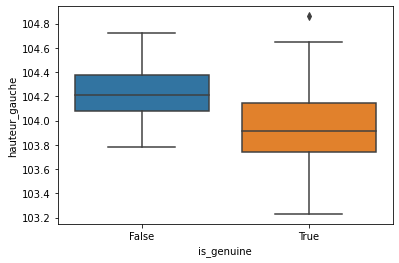

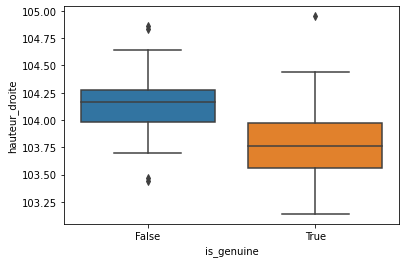

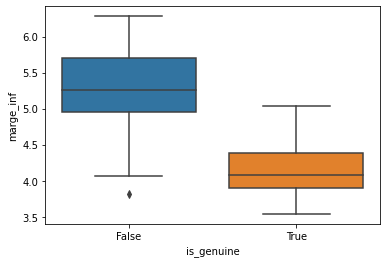

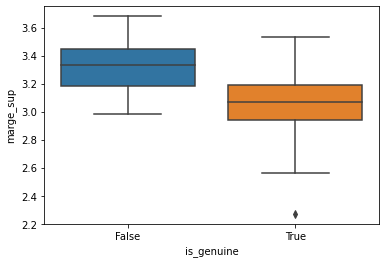

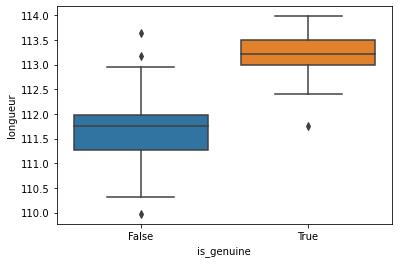

In [15]:
#univarié apres le describe 
for z in select:
    sns.boxplot(x='is_genuine',y=z, data=billet)
    plt.show()

In [16]:
for z in select:
    print(z.capitalize())
    X = billet['is_genuine'] # qualitative
    Y = billet[z] # quantitative
    print('eta-squared :', eta_squared(X,Y))

Diagonal
eta-squared : 0.019383108567093802
Hauteur_gauche
eta-squared : 0.21319458315018705
Hauteur_droite
eta-squared : 0.30394154672012125
Marge_inf
eta-squared : 0.640177214288775
Marge_sup
eta-squared : 0.3396567096032002
Longueur
eta-squared : 0.6818507654957807


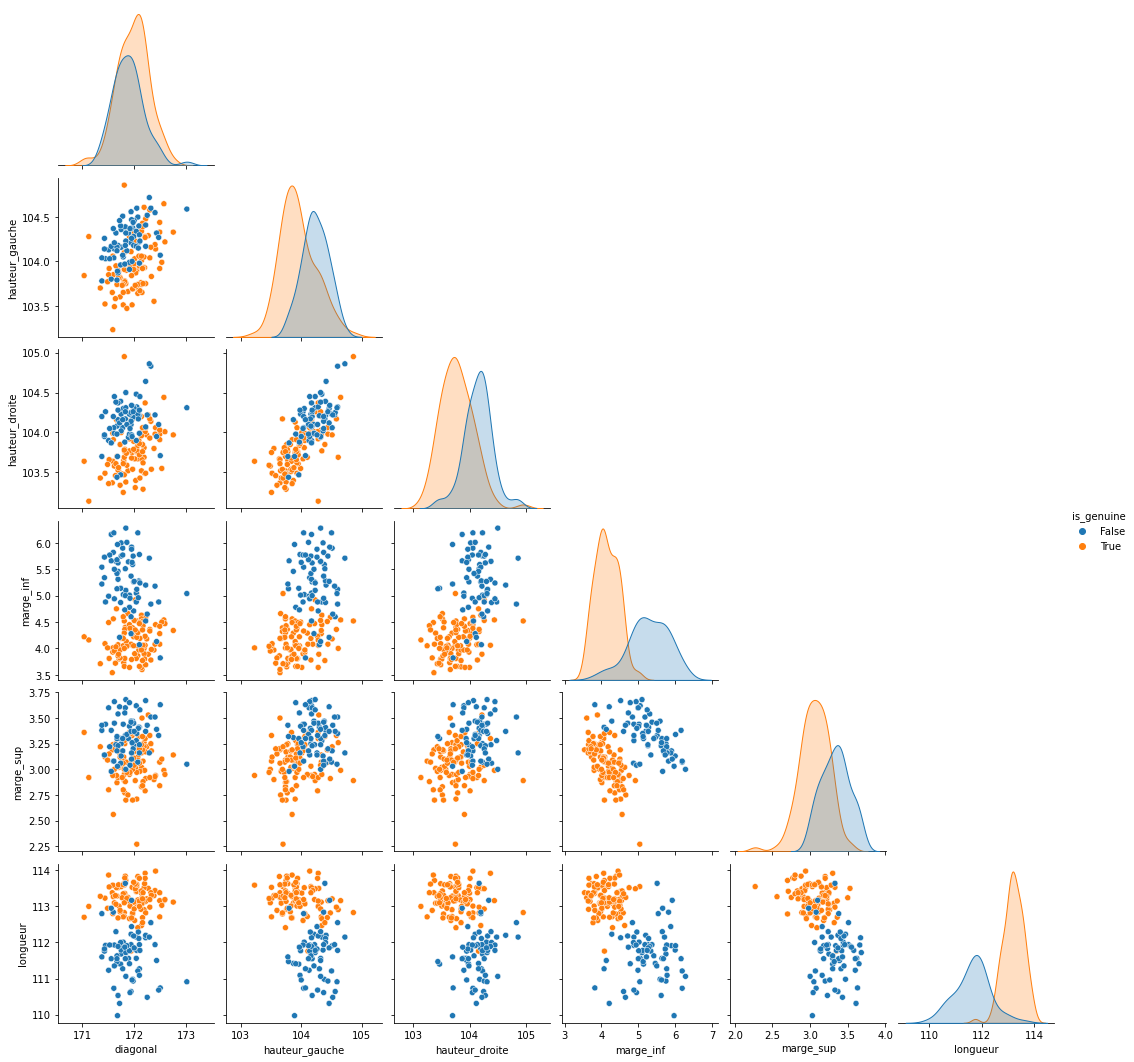

In [17]:
#Analyse bivarié
sns.pairplot(billet, hue='is_genuine', corner=True)
plt.show()

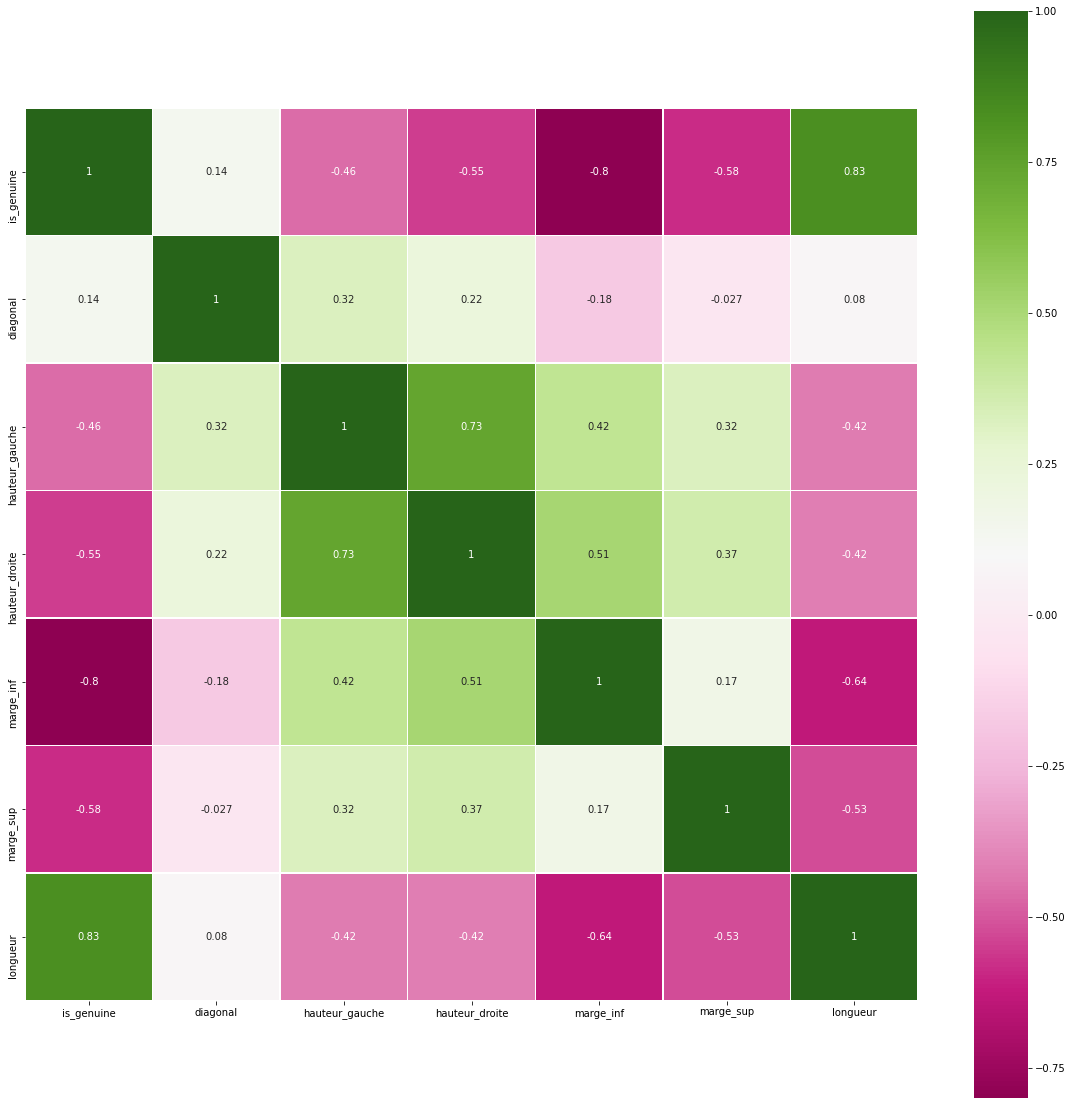

In [18]:
#faire une heatmap
#Matrice corrélation
billet_map = billet.corr()
plt.figure(figsize=(20,20))
sns.heatmap(billet_map, square=True, annot=True, linewidths=.5,cmap="PiYG")
plt.show()


# Analyse en composante principal (PCA)

In [19]:
# On crée les différents composants nécessaires à l'ACP
n_comp = 6
data_pca = billet.drop(columns='is_genuine')

X = data_pca.values
names = data_pca.index
features = data_pca.columns

In [20]:
# On prépare les données en faisant une normalisation (centrage-réduction)
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [21]:
# On applique l'ACP sur nos données transformées
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

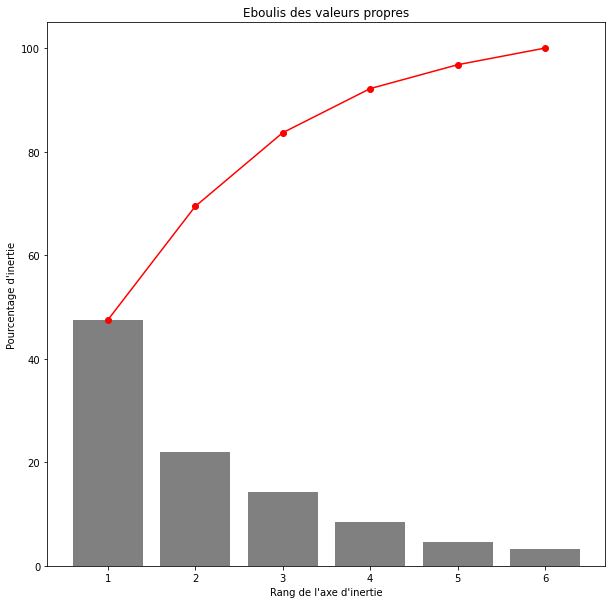

In [22]:
# On affiche l'éboulis des valeurs propres
# On pourra voir le pourcentage d'inertie pour chaque composante

fig, ax = plt.subplots(figsize=(10,10))
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree, color='gray')
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

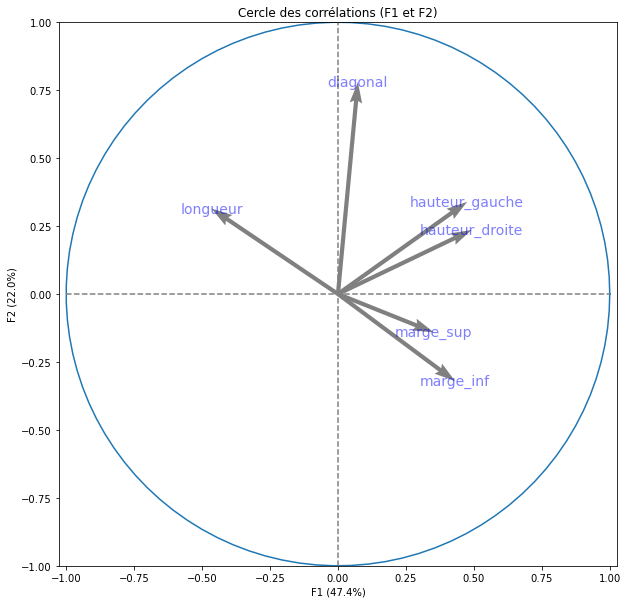

In [23]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))



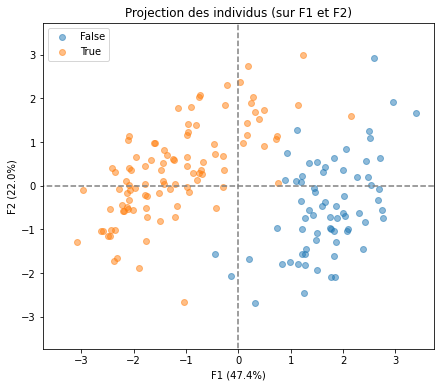

In [24]:
clusters=billet['is_genuine']
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = clusters , alpha = 0.5)

plt.show()



In [25]:
#interpreter l'acp
#on est limité a 3 variables  pour les representation 

In [26]:
#calculer la contribution
#contribution des individus dans l'inertie totale
#Pour calculer la qualité de la représentation des individus sur les axes, nous devons d’abord calculer les carrés des
#distances à l’origine des individus, qui correspondent également à leur contribution dans
#l’inertie totale
di = np.sum(X_scaled**2,axis=1)
print(pd.DataFrame({'ID':data_pca.index,'d_i':di,'is_genuine':billet['is_genuine']}))

      ID        d_i  is_genuine
0      0  18.410598        True
1      1   5.444799        True
2      2   4.960527        True
3      3   4.805719        True
4      4  18.039567        True
..   ...        ...         ...
165  165   7.673233       False
166  166  20.625650       False
167  167   8.567410       False
168  168   3.482926       False
169  169   5.369633       False

[170 rows x 3 columns]


In [27]:
#qualité de représentation des individus - COS2
#La somme des 2 cos devrait etre egale à 1?

cos2 = X_projected**2
for j in range(n_comp):
 cos2[:,j] = cos2[:,j]/di
print(pd.DataFrame({'id':data_pca.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1],'is_genuine':billet['is_genuine']}))


      id    COS2_1    COS2_2  is_genuine
0      0  0.251929  0.139000        True
1      1  0.818002  0.050822        True
2      2  0.784862  0.000466        True
3      3  0.882856  0.001652        True
4      4  0.320145  0.009417        True
..   ...       ...       ...         ...
165  165  0.800651  0.004703       False
166  166  0.324059  0.411824       False
167  167  0.498809  0.083461       False
168  168  0.156908  0.271800       False
169  169  0.421817  0.217111       False

[170 rows x 4 columns]


In [28]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [29]:
#obtenir les variances
#(valeurs propres, λk) associées aux axes factoriels
n = data_pca.shape[0]
#valeur corrigée
eigval = (n-1)/n*pca.explained_variance_


In [30]:
#contributions aux axes
#Contribution des individus aux axes (CTR). Elles permettent de déterminer les
#individus qui pèsent le plus dans la définition de chaque facteur.
#X_projected sont les indivus projecter se sont pas les variables d'origines
ctr = X_projected**2
for j in range(n_comp):
 ctr[:,j] = ctr[:,j]/(n*eigval[j])

print(pd.DataFrame({'id':data_pca.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))

      id     CTR_1     CTR_2
0      0  0.009584  0.011426
1      1  0.009203  0.001236
2      2  0.008045  0.000010
3      3  0.008767  0.000035
4      4  0.011933  0.000759
..   ...       ...       ...
165  165  0.012694  0.000161
166  166  0.013811  0.037927
167  167  0.008830  0.003193
168  168  0.001129  0.004227
169  169  0.004680  0.005205

[170 rows x 3 columns]


In [31]:
#vérifions la théorie
print(np.sum(ctr,axis=0))


[1. 1. 1. 1. 1. 1.]


In [32]:
#le champ components_ de l'objet ACP
#Représentation des variables – Outils pour l’aide à l’interprétation
#Nous avons besoin des vecteurs propres pour l’analyse des variables. Ils sont fournis par le
#champ .components_
print(pca.components_)

[[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
 [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
 [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
 [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]
 [-0.22509444  0.71592059 -0.48699285 -0.31190784 -0.1939426  -0.25441684]
 [ 0.12216606  0.23213146 -0.4808135   0.54763041  0.35437971  0.52395111]]


In [33]:
#Tenir compte des problemes de correlations en ma multipliant par la racine carée des valeur propres
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

In [34]:

#corrélation des variables avec les axes
corvar = np.zeros((n_comp,n_comp))
for k in range(n_comp):
 corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(corvar)

[[ 0.1236346   0.89486346 -0.08215244 -0.40034612 -0.11841965  0.05370861]
 [ 0.80229967  0.38938864  0.11345001  0.19887167  0.37663775  0.10205336]
 [ 0.8298348   0.27035382  0.14216371  0.32825381 -0.25620145 -0.21138296]
 [ 0.72725782 -0.36790977  0.4739162  -0.16202319 -0.1640912   0.24075808]
 [ 0.59482939 -0.1619761  -0.75887278  0.09680115 -0.10203101  0.15579811]
 [-0.78520903  0.36102241  0.11728832  0.41033916 -0.13384583  0.23034781]]


In [35]:
#on affiche pour les deux premiers axes
#
print(pd.DataFrame({'id':data_pca.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

               id     COR_1     COR_2
0        diagonal  0.123635  0.894863
1  hauteur_gauche  0.802300  0.389389
2  hauteur_droite  0.829835  0.270354
3       marge_inf  0.727258 -0.367910
4       marge_sup  0.594829 -0.161976
5        longueur -0.785209  0.361022


In [36]:
#Qualité de représentation des variables (COS²). On peut calculer la qualité de
#représentation des variables en montant la corrélation au carré :
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data_pca.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))


               id    COS2_1    COS2_2
0        diagonal  0.015286  0.800781
1  hauteur_gauche  0.643685  0.151624
2  hauteur_droite  0.688626  0.073091
3       marge_inf  0.528904  0.135358
4       marge_sup  0.353822  0.026236
5        longueur  0.616553  0.130337


In [37]:
#contributions
#Contribution des variables aux axes (CTR). La contribution est également basée sur le
#carré de la corrélation, mais relativisée par l’importance de l’axe
ctrvar = cos2var
for k in range(n_comp):
 ctrvar[:,k] = ctrvar[:,k]/eigval[k]
#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':data_pca.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))


               id     CTR_1     CTR_2
0        diagonal  0.005369  0.607837
1  hauteur_gauche  0.226102  0.115091
2  hauteur_droite  0.241888  0.055480
3       marge_inf  0.185784  0.102744
4       marge_sup  0.124284  0.019915
5        longueur  0.216572  0.098933


# mission 2 apprentissage non supervisé

# Kmeans

In [38]:
X = billet.values

km = KMeans(n_clusters=2)
km.fit(X)
clusterya = km.labels_

In [39]:
data_clusterya = pd.DataFrame({'clusters_kmeans' : clusterya})
billet = billet.join(data_clusterya)
illustrative_var = billet['clusters_kmeans']

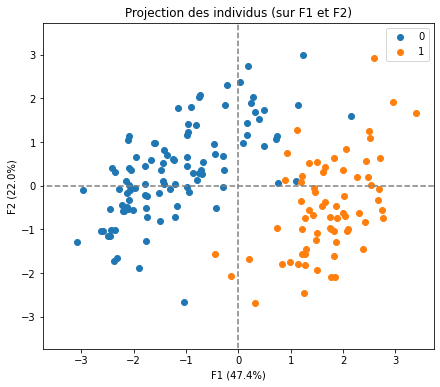

In [40]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=illustrative_var)


# Régression Logistique

In [41]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics


In [42]:
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_genuine       170 non-null    bool   
 1   diagonal         170 non-null    float64
 2   hauteur_gauche   170 non-null    float64
 3   hauteur_droite   170 non-null    float64
 4   marge_inf        170 non-null    float64
 5   marge_sup        170 non-null    float64
 6   longueur         170 non-null    float64
 7   clusters_kmeans  170 non-null    int32  
dtypes: bool(1), float64(6), int32(1)
memory usage: 8.9 KB


In [43]:
billet


,is_genuine,diagonal,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,longueur,clusters_kmeans
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0
1,True,171.67,103.74,103.70,4.01,2.87,113.29,0
2,True,171.83,103.76,103.76,4.40,2.88,113.84,0
3,True,171.80,103.78,103.65,3.73,3.12,113.63,0
4,True,172.05,103.70,103.75,5.04,2.27,113.55,0
...,...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78,1
166,False,173.01,104.59,104.31,5.04,3.05,110.91,1
167,False,172.47,104.27,104.10,4.88,3.33,110.68,1
168,False,171.82,103.97,103.88,4.73,3.55,111.87,1


In [44]:
billet=billet.astype({"is_genuine":'int64'})

In [45]:
billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_genuine       170 non-null    int64  
 1   diagonal         170 non-null    float64
 2   hauteur_gauche   170 non-null    float64
 3   hauteur_droite   170 non-null    float64
 4   marge_inf        170 non-null    float64
 5   marge_sup        170 non-null    float64
 6   longueur         170 non-null    float64
 7   clusters_kmeans  170 non-null    int32  
dtypes: float64(6), int32(1), int64(1)
memory usage: 10.1 KB


In [46]:
billet

,is_genuine,diagonal,hauteur_gauche,hauteur_droite,marge_inf,marge_sup,longueur,clusters_kmeans
0,1,171.81,104.86,104.95,4.52,2.89,112.83,0
1,1,171.67,103.74,103.70,4.01,2.87,113.29,0
2,1,171.83,103.76,103.76,4.40,2.88,113.84,0
3,1,171.80,103.78,103.65,3.73,3.12,113.63,0
4,1,172.05,103.70,103.75,5.04,2.27,113.55,0
...,...,...,...,...,...,...,...,...
165,0,172.11,104.23,104.45,5.24,3.58,111.78,1
166,0,173.01,104.59,104.31,5.04,3.05,110.91,1
167,0,172.47,104.27,104.10,4.88,3.33,110.68,1
168,0,171.82,103.97,103.88,4.73,3.55,111.87,1


In [47]:
#Préparation des données
X = billet.iloc[:, [1,2,3,4,5,6]]
y = billet.iloc[:,-1]

In [48]:
#Séparation entre les données d'entrainement et les données test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [49]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#verification de la colinéarité des des variable avec le VIF
reg_multi = smf.ols('diagonal ~ hauteur_gauche + hauteur_droite + marge_inf + marge_sup + longueur', data=billet).fit()
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[2.2498312129958937,
 2.5637087947433224,
 2.172802257913994,
 1.6252305296552287,
 2.4638364354834295]

In [51]:
y_pred = lr.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[17  1]
 [ 1 15]]


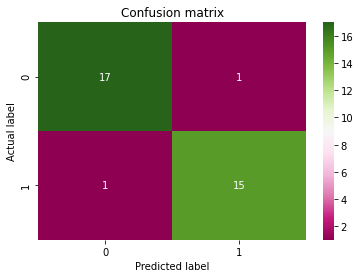

In [52]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="PiYG" ,fmt='g')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


plt.show()

In [53]:
#Récupération de la prédiction de la valeur positive
y_prob = lr.predict_proba(X_test)[:,1] 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

In [54]:
#Mesure AUC (Area Under the Curve): Aire sous la courbe
metrics.auc(false_positive_rate, true_positive_rate)

0.9965277777777778

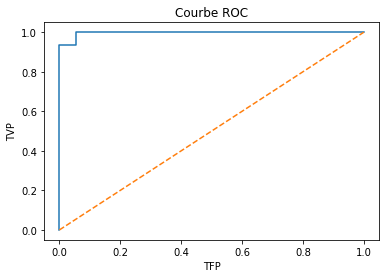

In [55]:
#Courbe ROC
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('TFP')
plt.ylabel('TVP')
plt.title('Courbe ROC')

plt.show()


In [56]:
#Autres métriques d'évaluation du modèle 
print('  - Accuracy:' +str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)), '%')
print('  - Precision:' +str(round(metrics.precision_score(y_test, y_pred)*100, 2)), '%')
print('  - Recall:' +str(round(metrics.recall_score(y_test, y_pred)*100, 2)), '%')
print('  - F1 score:' +str(round(metrics.f1_score(y_test, y_pred)*100, 2)), '%')

  - Accuracy:94.12 %
  - Precision:93.75 %
  - Recall:93.75 %
  - F1 score:93.75 %


# Fichier test

In [57]:
#Prédiction faite à partir du fichier "test_example.csv"
df = pd.read_csv('example.csv')
df


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [58]:
#Préparation des données
X = df.copy()
X = X.iloc[:, [0,1,2,3,4,5]]

In [59]:
#Utilisation du modèle de prédiction 'lr'
probability = lr.predict_proba(X.values)[:,1]

In [60]:
#Probabilités des billets établies 
proba = pd.Series(probability.round(3), name='value')
#Intégration des probabilités dans le jeu de données
df1 = pd.concat([df, proba], axis=1)
df1

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.947
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.976
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.967
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.114
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.004


In [61]:
res=[]
for i in df1['value']>= 0.5:
    if i is True:
        res.append('Vrai Billet')
    else :
        res.append('Faux Billet')

df1['resultat'] = res
df1

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value,resultat
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.947,Vrai Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.976,Vrai Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.967,Vrai Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.114,Faux Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.004,Faux Billet
